# kNN

First we import our data and we transfrom the y_samples and y_test into vectors with integers where if the outcome is malignant we write 1 and 0 if it is benign. 

Normalization when working with distance metric is very important, since working with vastly different ranges can render one or some predictor variables to dominate the distances. Hence we standardise the X_samples and X_test data. Since the size of the sample data is bigger than the size of the test data, we use the estimates of the mean and standard deviation from the larger data sets on the tumour_test datasets as well, as it is more reliable (this might not be the case if the two datasets are taken from different regions, however, here we assume that the data is separated into samples and test sets randomly).

Then, similar to the coding task, we create a couple of functions that help us train a KNN classifier. 

In [7]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
tumour_samples = pd.read_csv('tumour_samples.csv')
tumour_test = pd.read_csv('tumour_test.csv')

In [9]:
# Convert categorical labels to numbers
diagnosis_map = {'M': 1, 'B': 0}

# Import and standardise predictor train data
X_tumor_samples = tumour_samples.iloc[:,1:-1].to_numpy()
# Save the mean and std to standardize the X_tumor_test dataset
mu, sigma = np.mean(X_tumor_samples, axis = 0), np.std(X_tumor_samples, axis = 0)
# Standardize
X_tumor_samples_std = (X_tumor_samples - mu) / sigma

# Import outcome train data
y_tumor_samples = tumour_samples['DIAGNOSIS'].map(diagnosis_map).to_numpy()

# Import and standardise predictor test data
X_tumor_test = tumour_test.iloc[:,1:-1].to_numpy()
X_tumor_test_std = (X_tumor_test - mu) / sigma

# Import outcome test data
y_tumor_test = tumour_test['DIAGNOSIS'].map(diagnosis_map).to_numpy()

In [10]:
def euclidian_distance(p, q):
    """Returns the Euclidean distance between two points."""
    
    return np.sqrt(np.sum((p-q)**2, axis=1))

In [11]:
def k_neighbours(X_train, X_test, k):
    """Returns the k neighbours which are closest to our test points."""

    neighbours_indexes = []

    # Compute distance from each point x_test in X_test to all points in X_train
    point_distance = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # Determine which k training points are closest to each test point
    for row in point_distance:
        enum_neighbour = enumerate(row)
        sorted_neighbour = sorted(enum_neighbour, key=lambda x: x[1])[:k]
        ind_list = [tup[0] for tup in sorted_neighbour]
        neighbours_indexes.append(ind_list)
  
    return np.array(neighbours_indexes)

In [12]:
def predict(X_train, y_train, X_test, k):
    """Returns our prediction on how any testing point is classified."""
    
    # Each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k)

    # Count number of occurences of label with np.bincount and choose the label that has most with np.argmax
    y_prediction = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])
    
    return y_prediction

In [13]:
def score_knn(X_train, y_train, X_test, y_test, k):
    """Computes the proportion of the correctly classified test points."""

    # compute our predictions
    y_prediction = predict(X_train, y_train, X_test, k)

    # calculate the proportion
    score = np.mean(y_prediction == y_test)
    
    return score

In [14]:
def cross_validation_score_knn(X_train, y_train, folds, k, print_accuracy=True):
  """Computes the average score over n-fold cross validation for a given k."""
  
  scores = []

  # Set train and validation indices
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    # Separate the data into training and validation
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]
    X_val_i = X_train[val_indexes, :]
    y_val_i = y_train[val_indexes]

    # Compute the score for this fold
    score_i = score_knn(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
    scores.append(score_i)
    if print_accuracy == True:
      print("Accuracy on validation set #{}: {}".format(i+1, score_i))

  # Return the average score
  return np.mean(scores)

In [15]:
def choose_best_k(X_train, y_train, folds, k_range, print_accuracy = True):
  """Find the optimal value for the parameter k over the range k_range."""

  # Initialize scores
  k_scores = np.zeros(len(k_range))
  
  # Loop over each k and store the score 
  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score_knn(X_train,
                                             y_train,
                                             folds,
                                             k,
                                             print_accuracy)
    # Print the accuracy for each fold
    print(f'Average accuracy over {len(folds)} folds at k={k}: {k_scores[i]:}')
    print("_"*60)
  
  # Find the index of the k corresponding to the largest score
  best_k_index = np.argmax(k_scores)
  
  # Return the optimal value for k
  return k_range[best_k_index]


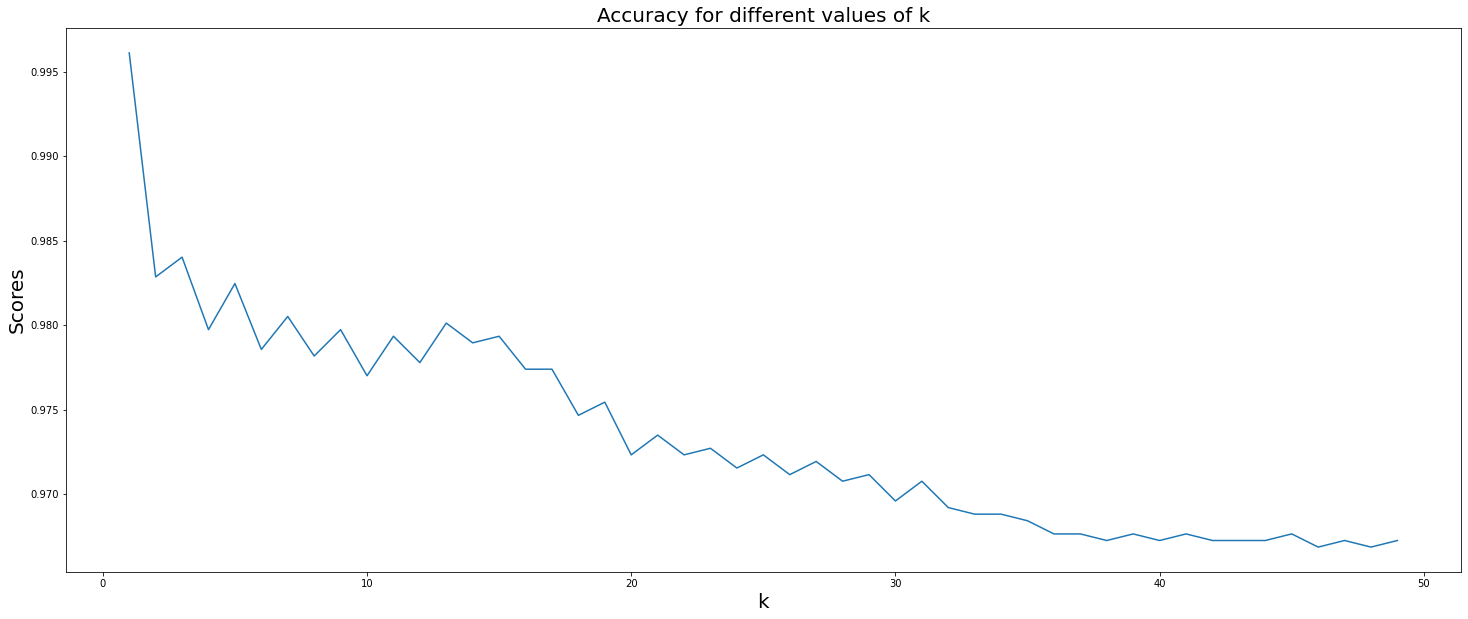

In [16]:
# Create folds
folds = np.array_split(np.arange(len(y_tumor_samples)), 5)

# Set the range for k
k_range = np.arange(1,50)

# Store scores for k in the k_range
scores_knn = [cross_validation_score_knn(X_tumor_samples_std, 
                                         y_tumor_samples,
                                         folds,
                                         k,
                                         print_accuracy=False) for k in k_range]

# Plot
plt.figure(figsize=(25,10))
plt.plot(k_range, scores_knn)
plt.title("Accuracy for different values of k", size=20)
plt.xlabel("k", size=20)
plt.ylabel("Scores", size=20)
plt.show()

From the plot we can see that the highest value of the accuracy is for $k=1$. Below we use our choose_best_k function to confirm that this is the case for a smaller range for $k$ and we also print the accuracy for each fold and the mean accuracy of all $5$ folds for each $k$ to demonstrate the grid search with $5$-fold cross-validation.

In [17]:
# Set k_range from 1 to 4
k_range = np.arange(1, 5)

# compute the optimal value of k
optimal_k = choose_best_k(X_tumor_samples_std,
                          y_tumor_samples,
                          folds,
                          k_range)

# Print optimal k
print('The optimal value of k is:', optimal_k)

Accuracy on validation set #1: 0.9902723735408561
Accuracy on validation set #2: 1.0
Accuracy on validation set #3: 1.0
Accuracy on validation set #4: 0.9902534113060428
Accuracy on validation set #5: 1.0
Average accuracy over 5 folds at k=1: 0.9961051569693797
____________________________________________________________
Accuracy on validation set #1: 0.9785992217898832
Accuracy on validation set #2: 0.98635477582846
Accuracy on validation set #3: 0.98635477582846
Accuracy on validation set #4: 0.9727095516569201
Accuracy on validation set #5: 0.9902534113060428
Average accuracy over 5 folds at k=2: 0.9828543472819533
____________________________________________________________
Accuracy on validation set #1: 0.9785992217898832
Accuracy on validation set #2: 0.9902534113060428
Accuracy on validation set #3: 0.98635477582846
Accuracy on validation set #4: 0.9746588693957114
Accuracy on validation set #5: 0.9902534113060428
Average accuracy over 5 folds at k=3: 0.984023937925228
_________

We see that the optimal $k$ is $1$ and the average accuracy over the $5$ validation sets is $0.9961051569693797$, which is very high suggesting that our model could have high accuracy predictions. This means that each object is simply assigned to the class of that single nearest neighbor.

We now fix $k = $ optimal_k and retrain the model on the whole sample dataset. First we print the accuracy on the entire training set and then we find the accuracy for the test set.

In [18]:
# Find the accuracy on the sample set
tumor_sample_accuracy = score_knn(X_tumor_samples_std,
                                  y_tumor_samples,
                                  X_tumor_samples_std,
                                  y_tumor_samples,
                                  k=optimal_k)
print("Accuracy on the tumour_samples.csv dataset is: ", tumor_sample_accuracy)

# Find the accuracy on the test set
tumor_test_accuracy = score_knn(X_tumor_samples_std,
                                y_tumor_samples,
                                X_tumor_test_std,
                                y_tumor_test,
                                k=optimal_k)
print("Accuracy on the tumour_test.csv dataset is: ", tumor_test_accuracy)

Accuracy on the tumour_samples.csv dataset is:  1.0
Accuracy on the tumour_test.csv dataset is:  1.0


We expect the accuracy on the tumour_sample.csv dataset to be very high, since this contains only seen data. However, to check whether we have overfitted the model, we test the accuracy on an unseen before dataset (tumour_test.csv). As we can see, we get a $1.0$ accuracy for the test dataset as well so we can conclcude that our model is well generalized and a very good predictor for breast tumor diagnosis.